# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [4]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [5]:
data_tr = pd.read_csv('./data_topic/train.csv',header=None,names=['label','text'])
data_te = pd.read_csv('./data_topic/test.csv',header=None,names=['label','text'])
data_de = pd.read_csv('./data_topic/dev.csv',header=None,names=['label','text'])

In [6]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [7]:
#train data transformation
X_tr_raw = data_tr['text'].tolist()

#test data transformatino
X_te_raw = data_te['text'].tolist()

#development data transformatino
X_de_raw = data_de['text'].tolist()


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [8]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'us','they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [9]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    unigram = []
    bigram = []
    trigram = []
    # get unigram by using regex
    pattern = re.compile(token_pattern)
    x_re = pattern.findall(x_raw.lower())
    # remove stop words
    if ngram_range==(1,1):
        for i in range(len(x_re)):
            if x_re[i] not in stop_words:
                unigram.append(x_re[i])
                x = unigram
    # return bigram or trigram
    if ngram_range==(1,3):
        for i in range(len(unigram)-1):
            bigram.append((unigram[i],unigram[i+1]))
        for i in range(len(unigram)-2):
            trigram.append((unigram[i],unigram[i+1],unigram[i+2]))
        x = unigram + bigram + trigram
        
    if ngram_range==(1,2):
        for i in range(len(unigram)-1):
            bigram.append((unigram[i],unigram[i+1]))
        x = unigram + bigram
    if vocab:
        x = list(vocab)
    return x
    



### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [10]:
def get_vocab(X_raw,ngram_range=(1,1),token_pattern=r'\b[A-Za-z][A-Za-z]+\b',keep_topN=0,
              min_df=0,stop_words=[]):
    ngrams = []
    ngrams_df = []
    for i in X_raw:
        n_grams = extract_ngrams(i,ngram_range=ngram_range,token_pattern=token_pattern,stop_words=stop_words)
        ngrams += n_grams
        ngrams_df += list(set(n_grams))
    more_frequent_ngrams = Counter(ngrams).most_common(keep_topN)
    #get more frequent ngrams key
    features = []
    ngram_counts = 0
    for k in more_frequent_ngrams:
        features.append(k[0])
        ngram_counts += k[1]
    vocab = set(features)
    #get document frequency for ngrams
    df = Counter(ngrams_df)
    # set min df for ngrams whose df is 0 
    for i in features:
        if i not in ngrams_df:
            df[i]=min_df
    return vocab, df, ngram_counts
    

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [11]:
vocab, df, ngram_counts = get_vocab(X_tr_raw,ngram_range=(1,1),stop_words=stop_words,keep_topN=5000)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['regain', 'vatican', 'crew', 'dominant', 'automaker', 'casino', 'impact', 'pies', 'outfielder', 'insurgents', 'schoolchildren', 'alison', 'wake', 'streets', 'landslides', 'gatumba', 'dot', 'rwanda', 'swimmer', 'golden', 'centers', 'chose', 'glory', 'insisting', 'delta', 'device', 'races', 'desktops', 'costa', 'any', 'backpacker', 'hilton', 'zimbabwe', 'present', 'favorite', 'guarded', 'humanitarian', 'controlling', 'demonstration', 'should', 'qualified', 'per', 'outcome', 'recorded', 'fly', 'bulls', 'overseas', 'check', 'training', 'frozen', 'lately', 'beck', 'country', 'senator', 'milk', 'jails', 'joy', 'promote', 'assailants', 'africans', 'bullish', 'kuwait', 'prosecutor', 'lo', 'substantially', 'brink', 'bitter', 'orders', 'nathan', 'arrivals', 'culture', 'brown', 'accounting', 'flag', 'decision', 'instance', 'junior', 'easy', 'child', 'consider', 'push', 'sohu', 'safety', 'got', 'cellular', 'needed', 'time', 'heat', 'stepped', 'operators', 'bradley', 'mixed', 'reflecting', '

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [12]:
id_word_dic = dict(enumerate(vocab))
word_id_dic = {v:k for k,v in id_word_dic.items()}

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [13]:
def get_X_unigram(X_raw,vocab,ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',stop_words=stop_words):
    # create a list of docs,each doc is a list of unigrams
    Unigrams = []
    for i in X_raw:
        unigrams = extract_ngrams(i,ngram_range=ngram_range,token_pattern=token_pattern,stop_words=stop_words)
        Unigrams.append(unigrams) 
    # store those unigrams which are in vocab    
    New_Unigram = []
    for doc in Unigrams:
        New_unigram = []
        for unigram in doc:
            if unigram in vocab:
                New_unigram.append(unigram)
        New_Unigram.append(New_unigram)
    return New_Unigram
X_uni_tr = get_X_unigram(X_tr_raw,vocab,ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',stop_words=stop_words)
X_uni_te = get_X_unigram(X_te_raw,vocab,ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',stop_words=stop_words)
X_uni_de = get_X_unigram(X_de_raw,vocab,ngram_range=(1,1), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',stop_words=stop_words)

In [14]:
X_uni_tr[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [15]:
def convert_index(X_uni,dic):
    X = []
    for doc in X_uni:
        x = []
        for unigram in doc:
            x.append(dic[unigram])
        X.append(x)
    return X
X_tr = convert_index(X_uni_tr,word_id_dic)
X_te = convert_index(X_uni_te,word_id_dic)
X_de = convert_index(X_uni_de,word_id_dic)           

In [16]:
X_tr[0]

[4931,
 1738,
 1173,
 4017,
 326,
 3394,
 4150,
 941,
 4976,
 4718,
 1284,
 3442,
 3774,
 4422,
 2116,
 2824,
 2871,
 3509,
 3383,
 4177,
 4646,
 541,
 3886,
 310,
 1323,
 698,
 1473]

Put the labels `Y` for train, dev and test sets into arrays: 

In [17]:
#train data transformation
Y_tr = np.array(data_tr['label'])
#test data transformatino
Y_te = np.array(data_te['label'])
#development data transformation
Y_de = np.array(data_de['label'])

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [18]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    W = {}
    W[0] = np.random.uniform(-init_val,init_val,(vocab_size,embedding_dim))
    if len(hidden_dim)==1:
        W[1] = np.random.uniform(-init_val,init_val,(embedding_dim,hidden_dim[0]))
        W[len(hidden_dim)+1] = np.random.uniform(-init_val,init_val,(hidden_dim[0],num_classes))
    if len(hidden_dim)>1:
        W[1] = np.random.uniform(-init_val,init_val,(embedding_dim,hidden_dim[0]))
        for i in range(len(hidden_dim)-1):
            W[i+2] = np.random.uniform(-init_val,init_val,(hidden_dim[i],hidden_dim[i+1]))
        W[len(hidden_dim)+1] = np.random.uniform(-init_val,init_val,(hidden_dim[-1],num_classes))
    if len(hidden_dim)==0:
        W[1] = np.random.uniform(-init_val,init_val,(embedding_dim,num_classes))
    W[0] = W[0].astype('float32')

    return W
    

In [19]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [20]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[3], num_classes=2)

In [21]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 3)
W_out: (3, 2)


In [22]:
W[0]

array([[-0.4042875 ,  0.38532683,  0.12724897,  0.22341636],
       [-0.4838708 ,  0.09443188,  0.05678519, -0.34104034],
       [-0.3469295 ,  0.19552954, -0.18123357,  0.19197029]],
      dtype=float32)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [23]:
def softmax(z):
    t = np.exp(z)
    smax = np.exp(z) / np.sum(t, axis=1).reshape(-1,1)
    return smax

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [24]:
def categorical_loss(y, y_preds):
    y_true = y_preds[y]
    l = -1*np.log(y_true)
    return l

In [25]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [26]:
def relu(z):
    a = z.copy()
    for i in range(len(a)):
        a[i]=max(0,a[i])
    return a
    
def relu_derivative(z):
    dz = z.copy()
    for i in range(len(dz)):
        if dz[i]<=0:
            dz[i]=0
        else:
            dz[i]=1
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [27]:
def dropout_mask(size, dropout_rate):
    dropout_vec = []
    index = []
    for i in range(size):
        dropout_vec.append(1)
        index.append(i)
    num = int(size*dropout_rate)
    random_index = random.sample(index,num)
    for i in random_index:
        dropout_vec[i] = 0
    return dropout_vec
    
    

In [28]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [29]:

def forward_pass(x, W, dropout_rate=0.2):
      
    out_vals = {}   
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    embedding_dim = W[0].shape[1]
    Wi = np.zeros((embedding_dim),dtype='float32')
    for word_index in x:
        Wi += W[0][word_index]
    h = 1/len(x)*Wi
    a = relu(h)
    dropout = np.array(dropout_mask(len(h),dropout_rate))
    h_vecs.append(h)
    a_vecs.append(a)
    dropout_vecs.append(dropout)
    if len(W)==2:
        y = softmax(np.dot(a*dropout.reshape(1,-1),W[1]))[0]  
        out_vals['h'] = h_vecs
        out_vals['a'] = a_vecs
        out_vals['dropout_vec'] = dropout_vecs
        out_vals['y'] = y
    else:
        for i in range(1,len(W)-1):
            h = np.dot(a*dropout,W[i])
            h_vecs.append(h)
            a = relu(h)
            a_vecs.append(a)
            dropout = np.array(dropout_mask(len(h),dropout_rate))
            dropout_vecs.append(dropout)
        y = softmax(np.dot(a*dropout.reshape(1,-1),W[len(W)-1]))[0] 
        out_vals['h'] = h_vecs
        out_vals['a'] = a_vecs
        out_vals['dropout_vec'] = dropout_vecs
        out_vals['y'] = y

    return out_vals
    

In [30]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.5))


Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([ 0.08821655,  0.02320107,  0.08164707, -0.04623899], dtype=float32), array([ 0.00049959, -0.01153817,  0.01133014,  0.00940436, -0.00678316])], 'a': [array([0.08821655, 0.02320107, 0.08164707, 0.        ], dtype=float32), array([0.00049959, 0.        , 0.01133014, 0.00940436, 0.        ])], 'dropout_vec': [array([0, 1, 0, 1]), array([0, 1, 1, 0, 1])], 'y': array([0.50063393, 0.49936607])}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [718]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    y_pred = out_vals['y']
    a = out_vals['a']
    h = out_vals['h']
    dropout = out_vals['dropout_vec']
    y_true = np.zeros(y_pred.shape[0])
    y_true[y-1] = 1
    n = len(W)
    X = np.zeros(len(W[0]))
    for i in x:
        X[i] = 1
    #output layer
    g = y_pred - y_true #(,3)
    g = g.reshape(1,-1) #convert to two dimention (1,3)
    dw = np.dot((a[-1]*dropout[-1]).reshape(1,-1).T,g) 
    g = np.dot(W[n-1],g.T)
    W[n-1] -= lr*dw
    # hidden layer
    for i in range(n-2,0,-1):
        g_h = g
        g = g_h*relu_derivative(h[i]).reshape(1,-1).T
        dw = np.dot((a[i-1]*dropout[i-1]).reshape(1,-1).T,g.T)
        g = np.dot(W[i],g)
        W[i] -= lr*dw
    # input layer
    if freeze_emb == False:
        g = g*relu_derivative(h[0]).reshape(1,-1).T
        dw = np.dot(X.reshape(1,-1).T,g.T)
        W[0] -= lr*dw
    
    return W


Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [679]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    avr_loss_de = 2
    training_loss_history = []
    validation_loss_history = []
    
    for i in range(epochs):
        # randomise order in training Data
        zipped = list(zip(X_tr,Y_tr))
        random.shuffle(zipped)
        for j in range(len(zipped)):
            shuffled_x = zipped[j][0]
            shuffled_y = zipped[j][1]
            out_vals = forward_pass(shuffled_x, W, dropout_rate=dropout)
            W = backward_pass(shuffled_x,shuffled_y, W, out_vals, lr=lr)
        # compute train data loss
        pre_loss_de = avr_loss_de
        sum_loss_tr = 0
        for k in range(len(X_tr)):
            x_tr_loss = categorical_loss(Y_tr[k]-1,forward_pass(X_tr[k],W,dropout_rate=dropout)['y'])
            sum_loss_tr += x_tr_loss
        avr_loss_tr = sum_loss_tr/len(X_tr)
        
        # compute valiadation data loss
        sum_loss_de = 0
        for l in range(len(X_de)):
            x_de_loss = categorical_loss(Y_de[l]-1,forward_pass(X_de[l],W,dropout_rate=dropout)['y'])
            sum_loss_de += x_de_loss
        avr_loss_de = sum_loss_de/len(X_de)
        
        training_loss_history.append(avr_loss_tr)
        validation_loss_history.append(avr_loss_de)
        if print_progress==True:
            print("Epoch: ",i,"| Training loss: ",avr_loss_tr,"| Validation loss: ",avr_loss_de)
            
        if (pre_loss_de - avr_loss_de) < tolerance:
            break
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [680]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3,init_val=0.1)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_de, 
                            Y_dev=Y_de,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)


Shape W0 (5000, 300)
Shape W1 (300, 3)
Epoch:  0 | Training loss:  1.0724445869773214 | Validation loss:  1.0816912717588412
Epoch:  1 | Training loss:  0.9924305862614153 | Validation loss:  1.0327057851305264
Epoch:  2 | Training loss:  0.821121959907465 | Validation loss:  0.9032226153263626
Epoch:  3 | Training loss:  0.6354251976463391 | Validation loss:  0.7368499242378554
Epoch:  4 | Training loss:  0.48756471831255604 | Validation loss:  0.5762578711347136
Epoch:  5 | Training loss:  0.38360105447466736 | Validation loss:  0.48053836991631943
Epoch:  6 | Training loss:  0.31299002091356853 | Validation loss:  0.4194821094886287
Epoch:  7 | Training loss:  0.2645247289377141 | Validation loss:  0.38745675487294223
Epoch:  8 | Training loss:  0.22627570149700896 | Validation loss:  0.3424679986627116
Epoch:  9 | Training loss:  0.19183074354040652 | Validation loss:  0.3180225230185826
Epoch:  10 | Training loss:  0.16739753903667468 | Validation loss:  0.309486046272848
Epoch:  

Plot the learning process:

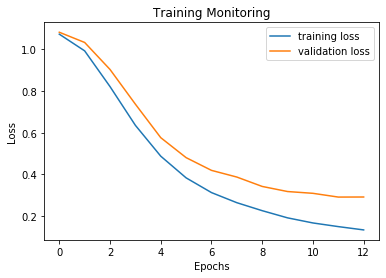

In [681]:
epochs = []
for i in range(len(loss_tr)):
    epochs.append(i)
plt.plot(epochs, loss_tr, label='training loss')
plt.plot(epochs, dev_loss, label='validation loss')
plt.legend()
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [682]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.86
Precision: 0.8626508899542715
Recall: 0.86
F1-Score: 0.8600087717211055


### Discuss how did you choose model hyperparameters ? 

I choose a small value for learning rate and decrease it to see if it can be converged. Then I changed embedding size to see how it can affect result. As regurlization part dropout, it can avoid overfitting if it increases. 

In [734]:
result_ave = {'learing rate':[0.001,0.01,0.1],
              'embedding size':[300,50,500],
              'dropout':[0.2,0.4,0.6],
              'training loss':[0.13,0.20,0.03],
              'validation loss':[0.29,0.36,0.28]}
pd.DataFrame(result_ave)

,learing rate,embedding size,dropout,training loss,validation loss
0,0.001,300,0.2,0.13,0.29
1,0.010,50,0.4,0.20,0.36
2,0.100,500,0.6,0.03,0.28


# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [620]:
word2id = word_id_dic

In [693]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [738]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [701]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3,init_val=0.1)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_de, 
                            Y_dev=Y_de,
                            lr=0.001, 
                            dropout=0.4,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=100)

Epoch:  0 | Training loss:  1.0172854462423895 | Validation loss:  1.0322356819912737
Epoch:  1 | Training loss:  0.9444392297410271 | Validation loss:  0.9752660058812223
Epoch:  2 | Training loss:  0.884974185260167 | Validation loss:  0.9236572735609495
Epoch:  3 | Training loss:  0.8357683878771647 | Validation loss:  0.8436085196555664
Epoch:  4 | Training loss:  0.788436561382132 | Validation loss:  0.8327010213928917
Epoch:  5 | Training loss:  0.7485650993599987 | Validation loss:  0.7916830669910401
Epoch:  6 | Training loss:  0.7100679243437574 | Validation loss:  0.7635749535647299
Epoch:  7 | Training loss:  0.674060167916679 | Validation loss:  0.7081399602248951
Epoch:  8 | Training loss:  0.6493662829574182 | Validation loss:  0.6966652215880879
Epoch:  9 | Training loss:  0.6201013991829882 | Validation loss:  0.6733397063829409
Epoch:  10 | Training loss:  0.5933183883765708 | Validation loss:  0.6457093687491999
Epoch:  11 | Training loss:  0.5765015622947441 | Valida

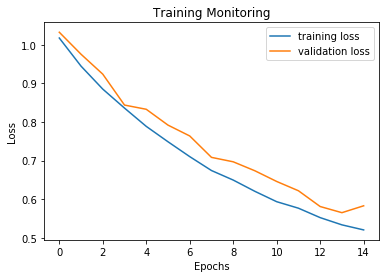

In [702]:
epochs = []
for i in range(len(loss_tr)):
    epochs.append(i)
plt.plot(epochs, loss_tr, label='training loss')
plt.plot(epochs, dev_loss, label='validation loss')
plt.legend()
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [703]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8933333333333333
Precision: 0.8929949503489713
Recall: 0.8933333333333332
F1-Score: 0.8929831087108734


### Discuss how did you choose model hyperparameters ? 

Like the average embedding without pre-trained before, I tune the learning rate first, then change the dropout to get better convergence. The embedding size is a constant number and it cannot be changed.
Because the embedding matrix is pre-trained rather than random values, it performs better and can get 89% accuracy.

In [744]:
result_pre = {'learing rate':[0.001,0.01,0.1],
              'dropout':[0.2,0.4,0.6],
              'training loss':[0.56,0.22,0.05],
              'validation loss':[0.61,0.29,0.29]}
pd.DataFrame(result_pre)

,learing rate,dropout,training loss,validation loss
0,0.001,0.2,0.56,0.61
1,0.010,0.4,0.22,0.29
2,0.100,0.6,0.05,0.29


# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [729]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[3], num_classes=3,init_val=0.1)
W[0] = w_glove
W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_de, 
                            Y_dev=Y_de,
                            lr=0.005, 
                            dropout=0.3,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=20)

Epoch:  0 | Training loss:  0.281853408562646 | Validation loss:  0.33241881586694677
Epoch:  1 | Training loss:  0.25040926782295625 | Validation loss:  0.2537727587386603
Epoch:  2 | Training loss:  0.2320210099285951 | Validation loss:  0.26416216159669387


In [730]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.87
Precision: 0.871396525812829
Recall: 0.8700000000000001
F1-Score: 0.8698344888774994


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.86  |  0.86 | 0.86  |  0.86 |
| Average Embedding (Pre-trained)  | 0.89  | 0.89  | 0.89  | 0.89  |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   | 0.86  | 0.86  | 0.86  | 0.87  |
